In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patient-survival-prediction-data/Dataset.csv


# Import library 

In [2]:
# file manipulation and visualization
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# TensorFlow and its submodules for machine learning tasks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
import keras_tuner as kt

2024-02-09 09:01:24.360350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 09:01:24.360443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 09:01:24.362244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import data 

In [3]:
df = pd.read_csv("/kaggle/input/patient-survival-prediction-data/Dataset.csv")

In [4]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Dataset have 
    
    178 Numerical features Column, 
    
    8 categorical features Column,  

In [6]:
df.shape

(91713, 186)

In [7]:
df.isnull().sum()

encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64

In [8]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [9]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Droping the columns that have unique values 
column = ['encounter_id', 'patient_id', 'hospital_id','hospital_admit_source','icu_admit_source','icu_stay_type', 'icu_id', 'readmission_status']
df = df.drop(columns = column, axis = 1)
df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.42,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.95,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.64,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [11]:
def missing_col(df):
    missing_df = pd.DataFrame(df.isnull().sum()/df.shape[0], columns = ["Missing"])
    return missing_df[missing_df["Missing"]>= 0.50]

print(f"{len(missing_col(df).index)} column have more than 50% null values.\n")
missing_val_col = list(missing_col(df).index)
print("Columns:", missing_val_col)

74 column have more than 50% null values.

Columns: ['albumin_apache', 'bilirubin_apache', 'fio2_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'urineoutput_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lacta

In [12]:
df = df.drop(columns=missing_val_col)

In [13]:
df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.42,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.95,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.64,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [14]:
print(df.shape)

(91713, 104)


In [15]:
df.isna().sum()

hospital_death                    0
age                            4228
bmi                            3429
elective_surgery                  0
ethnicity                      1395
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 104, dtype: int64

In [16]:
df=df[df[['bmi','weight','height']].isnull().sum(axis=1)==0]
df.isna().sum()

hospital_death                    0
age                            4055
bmi                               0
elective_surgery                  0
ethnicity                      1211
                               ... 
leukemia                        684
lymphoma                        684
solid_tumor_with_metastasis     684
apache_3j_bodysystem           1566
apache_2_bodysystem            1566
Length: 104, dtype: int64

In [17]:
def plot_count(df):
    # checking the target
    plt.figure(figsize=(15, 7))
    
    # Barplot
    ax1 = plt.subplot(1, 2, 1)
    cp = sns.countplot(x=df["hospital_death"])

    # Add count numbers on top of the bars
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=14)

    ax1.set_xlabel(" ")
    ax1.set_ylabel(" ")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine(top=True, right=True)

    # Pieplot
    ax2 = plt.subplot(1, 2, 2)
    plt.pie(df["hospital_death"].value_counts(),
            labels=list(df["hospital_death"].unique()),
            autopct='%1.2f%%',
            pctdistance=0.8,
            shadow=True,
            radius=1.3,
            textprops={'fontsize': 14},
            explode=[0.3, 0]
            )
    ax2.set_xlabel(" ")
    plt.xlabel('Composition of "Hospital Death"', fontsize=15, labelpad=20)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

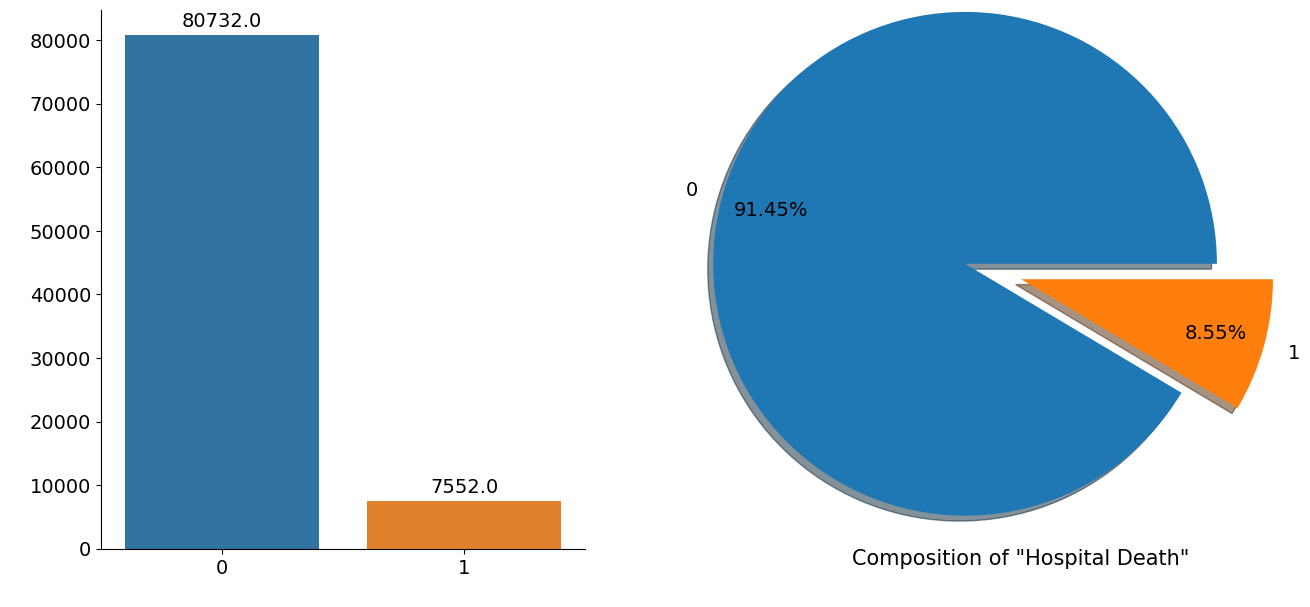

In [18]:
plot_count(df)

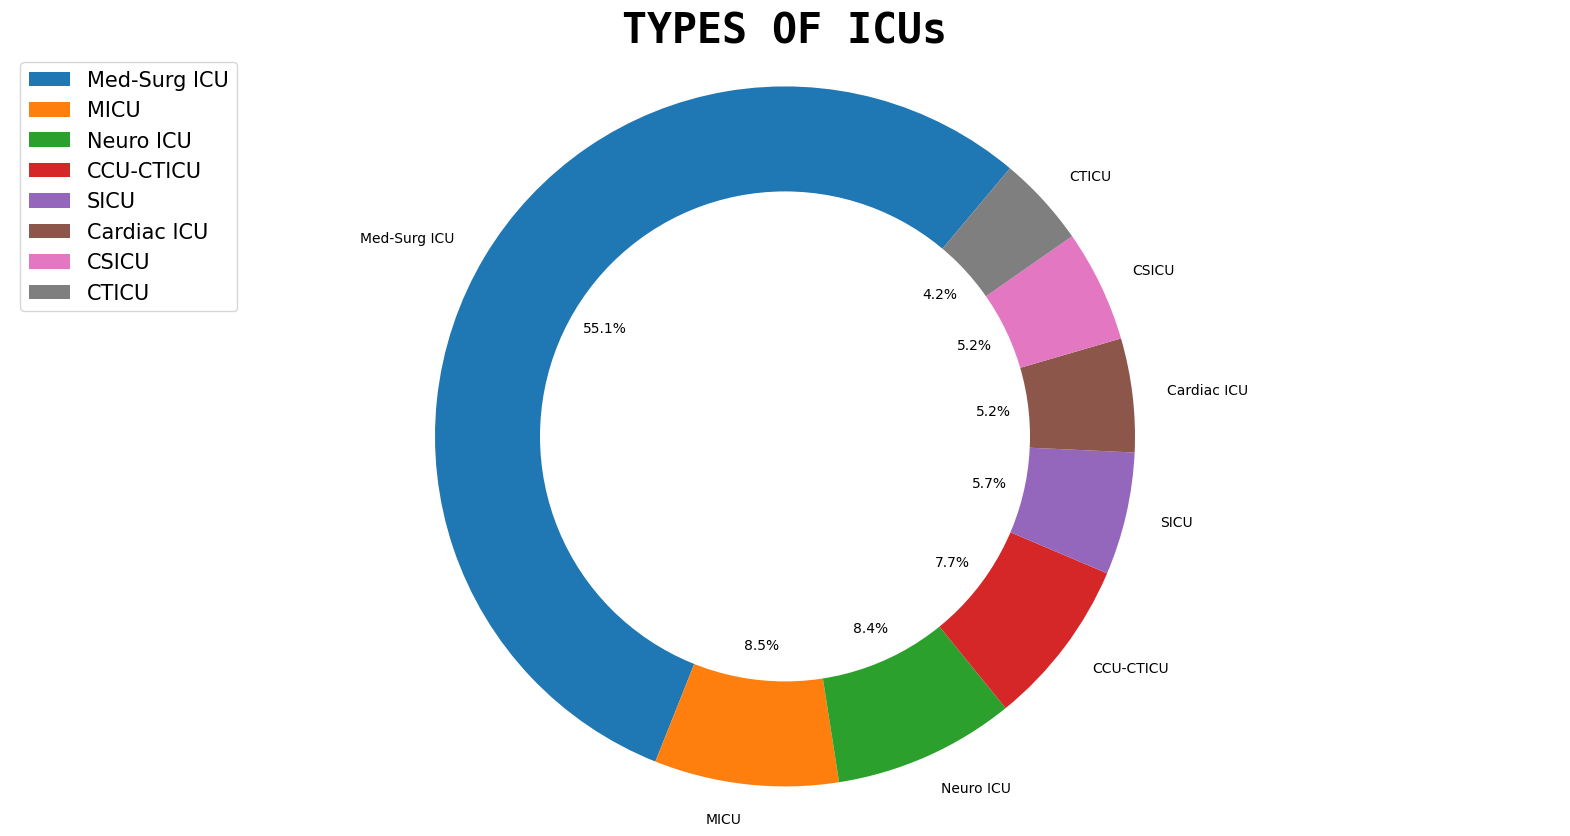

In [19]:
icu_type = df['icu_type'].value_counts()

plt.figure(figsize=(20, 10))
plt.pie(icu_type.values, labels=icu_type.index,
        startangle=50, autopct='%1.1f%%')
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('TYPES OF ICUs', fontdict={
          'fontname': 'Monospace', 'fontsize': 30, 'fontweight': 'bold'})
plt.axis('equal')
plt.legend(prop={'size': 15},loc='upper left')
plt.show()

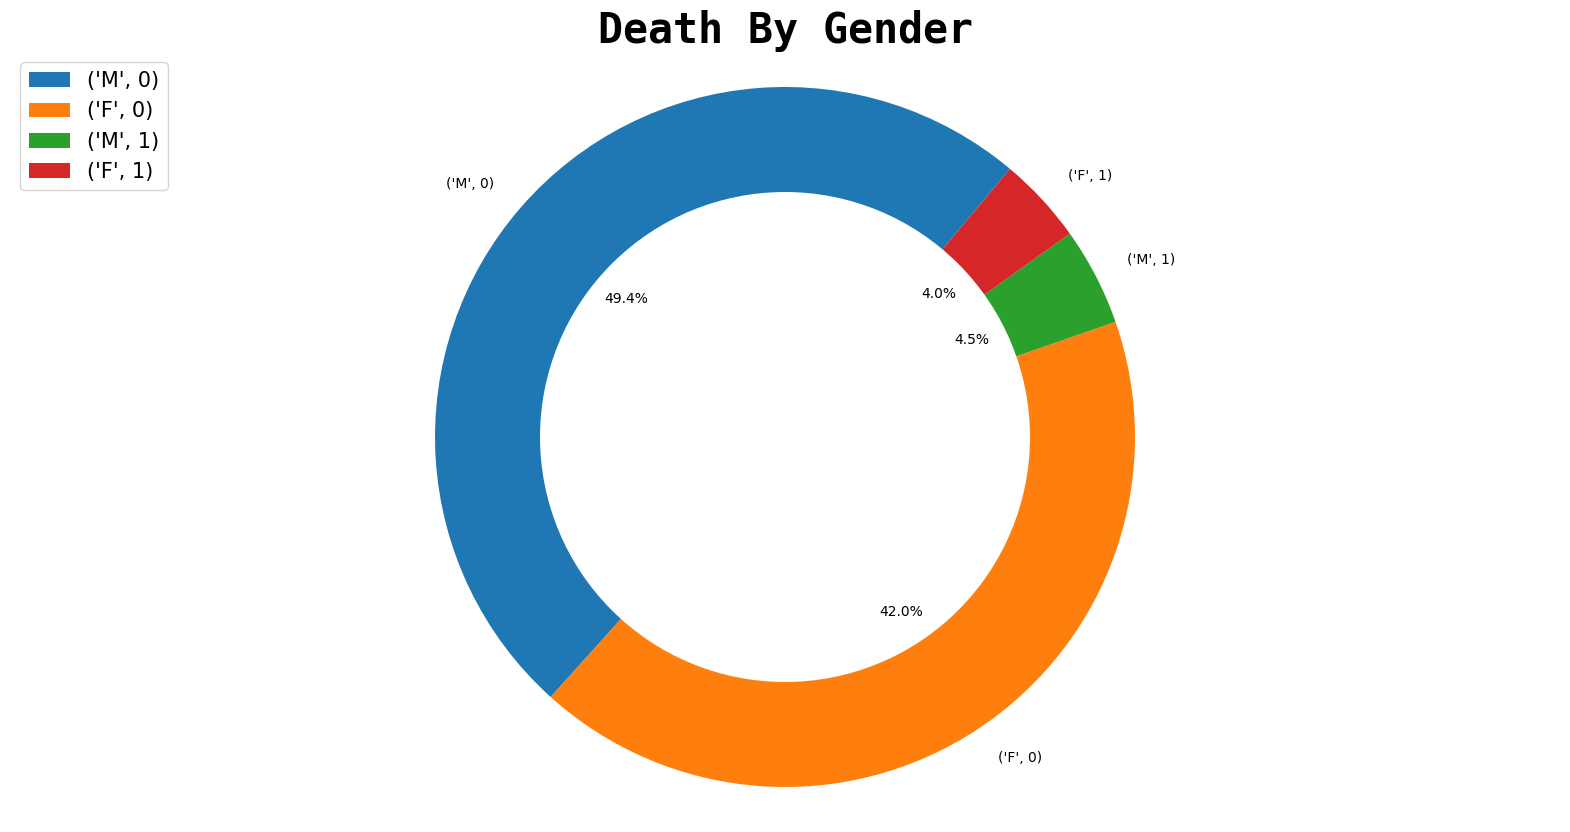

In [20]:
Hospital_death_by_ethinicity=df[['gender','hospital_death']].value_counts()
plt.figure(figsize=(20, 10))
plt.pie(Hospital_death_by_ethinicity.values, labels=Hospital_death_by_ethinicity.index,
        startangle=50, autopct='%1.1f%%')
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Death By Gender', fontdict={
          'fontname': 'Monospace', 'fontsize': 30, 'fontweight': 'bold'})
plt.axis('equal')
plt.legend(prop={'size': 15},loc='upper left')
plt.show()


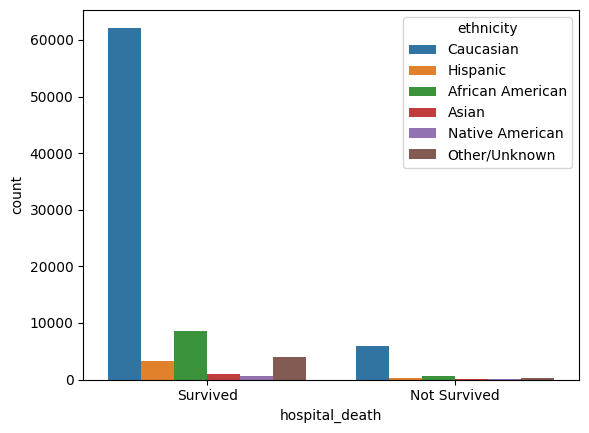

In [21]:
new=df['hospital_death'].apply(lambda x:'Survived' if x==0 else 'Not Survived')
sns.countplot(x=new,hue=df['ethnicity'])
plt.show()

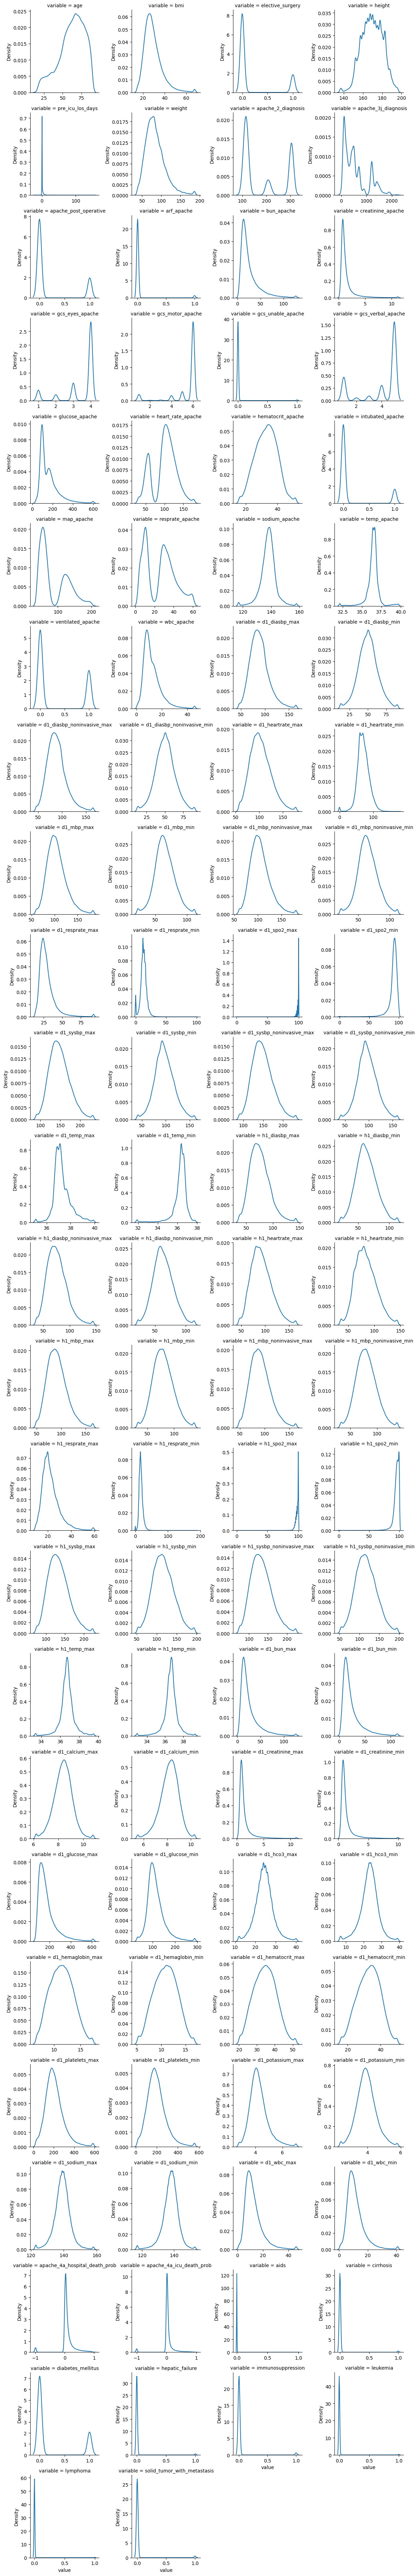

In [22]:
unpivot = pd.melt(df, df.describe().columns[0], df.describe().columns[1:])
g = sns.FacetGrid(unpivot, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

In [23]:
df['hospital_death'].value_counts()/df.shape[0]*100

hospital_death
0    91.445789
1     8.554211
Name: count, dtype: float64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Dataset have 91% patient survived and 8% not survived this means data is very imbalanced
    

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88284 entries, 0 to 91712
Columns: 104 entries, hospital_death to apache_2_bodysystem
dtypes: float64(96), int64(3), object(5)
memory usage: 70.7+ MB


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Dataset have 99 numerical feature column and 5 categorical column
    

In [25]:
cat_col = df.select_dtypes(include=object).columns.to_list()
cat_col

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [26]:
df.isna().sum()

hospital_death                    0
age                            4055
bmi                               0
elective_surgery                  0
ethnicity                      1211
                               ... 
leukemia                        684
lymphoma                        684
solid_tumor_with_metastasis     684
apache_3j_bodysystem           1566
apache_2_bodysystem            1566
Length: 104, dtype: int64

In [27]:
imputer=SimpleImputer(strategy='most_frequent')
df.iloc[:,:]=imputer.fit_transform(df)

In [28]:
##after filling missing values
df.isna().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
apache_2_bodysystem            0
Length: 104, dtype: int64

In [29]:
df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.42,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.95,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.64,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,0,67.0,27.56,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


# One Hot Encoder

In [30]:
cat_df = df[cat_col]
cat_df.head()

,ethnicity,gender,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,CTICU,Cardiovascular,Cardiovascular
5,Caucasian,M,Med-Surg ICU,Neurological,Neurologic


In [31]:
df_encoded=pd.get_dummies(df,columns=cat_col,drop_first=False,prefix='isIN',prefix_sep='_')
df_encoded.reset_index(drop=True,inplace=True)
df_encoded=df_encoded.applymap(lambda x:1 if x==True else (0 if x==False else x))

In [32]:
df_encoded.head()

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,isIN_Cardiovascular,isIN_Gastrointestinal,isIN_Haematologic,isIN_Metabolic,isIN_Neurologic,isIN_Renal/Genitourinary,isIN_Respiratory,isIN_Trauma,isIN_Undefined Diagnoses,isIN_Undefined diagnoses
0,0,68.0,22.73,0,180.3,0.541667,73.9,113.0,502.01,0,...,1,0,0,0,0,0,0,0,0,0
1,0,77.0,27.42,0,160.0,0.927778,70.2,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
2,0,25.0,31.95,0,172.7,0.000694,95.3,122.0,703.03,0,...,0,0,0,1,0,0,0,0,0,0
3,0,81.0,22.64,1,165.1,0.000694,61.7,203.0,1206.03,1,...,1,0,0,0,0,0,0,0,0,0
4,0,67.0,27.56,0,190.5,0.000694,100.0,301.0,403.01,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
df_encoded.shape

(88284, 136)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b>dropping one of categorical column becuse that is good practice to drop one categorical column after one hot encode</b><br>
</div>

## Separated train and test data

In [34]:
X = df_encoded.drop("hospital_death", axis=1)
y = df_encoded['hospital_death']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

In [36]:
print("Train data size: ", X_train.shape)
print("Test data size: ", y_train.shape)

Train data size:  (61798, 135)
Test data size:  (61798,)


In [37]:
# creating an instance for MinMaxScaler
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# storing the normalized data into a new dataframe
X_train_new = pd.DataFrame(X_train_std, columns= X_train.columns)
X_test_new = pd.DataFrame(X_test_std, columns= X_test.columns)

In [38]:
print("New train data shape:", X_train_new.shape)
print("New test data shape:", X_test_new.shape)

New train data shape: (61798, 135)
New test data shape: (26486, 135)


# Model Building 
### Model-1:Creating the Basic Deep Learning Model

In [39]:
model = Sequential()
# adding first layer and using relu as an activation function
model.add(Dense(64, input_shape=(X_train_new.shape[-1],), activation='relu'))
# adding second layer to the sequential model
model.add(Dense(32, activation='relu'))
# Adding third layer 
model.add(Dense(16, activation='relu'))
# adding output layer to the model using sigmoid activation function which seems to be ideal for binary classification problem
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8704      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11329 (44.25 KB)
Trainable params: 11329 (44.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# metrics that might be useful for present project
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')
]


### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(0.01),
              loss='binary_crossentropy',
              metrics=metrics)

In [42]:
### Training the model
epochs = 25
batch_size = 32
history = model.fit(X_train_new.values,y_train, validation_data = (X_test_new.values, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/25
1932/1932 [==============================] - 8s 3ms/step - loss: 0.2198 - precision: 0.6415 - recall: 0.1559 - auc: 0.8438 - val_loss: 0.2162 - val_precision: 0.6113 - val_recall: 0.3031 - val_auc: 0.8652
Epoch 2/25
1932/1932 [==============================] - 7s 4ms/step - loss: 0.2096 - precision: 0.6611 - recall: 0.2047 - auc: 0.8620 - val_loss: 0.2109 - val_precision: 0.6561 - val_recall: 0.2755 - val_auc: 0.8672
Epoch 3/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.2057 - precision: 0.6545 - recall: 0.2408 - auc: 0.8681 - val_loss: 0.2186 - val_precision: 0.7778 - val_recall: 0.1539 - val_auc: 0.8703
Epoch 4/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.2042 - precision: 0.6597 - recall: 0.2542 - auc: 0.8707 - val_loss: 0.2078 - val_precision: 0.6180 - val_recall: 0.3286 - val_auc: 0.8718
Epoch 5/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.2022 - precision: 0.6479 - recall: 0.2746 - auc: 0.8738 - 

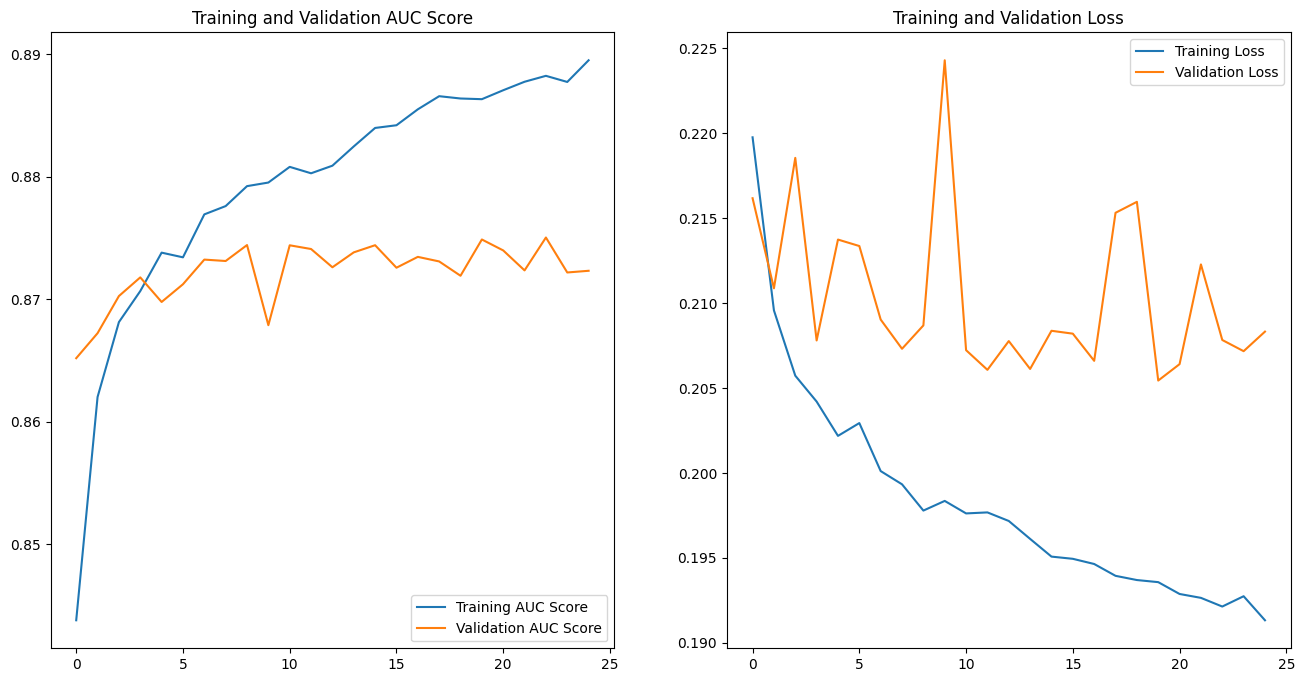

In [43]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC Score')
plt.plot(epochs_range, val_acc, label='Validation AUC Score')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Conclusion from Model 1:</font></h3>
    
- There is a large fluctuation in the validation loss using this model.
- The recall evaluation metric is also not giving very good results

# Model 2: Dealing with Class Imbalance
- Class Imbalance is a major issue when dealing with classification problem since one class dominates the other class with a large number.
- Keras can be used to deal with class imbalance problem by specifying the weights to the classes.
- Class with lesser number of samples can be given more weightage as compared to dominant class.

In [44]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_new.shape[-1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [45]:
metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')
]

### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=metrics)

In [46]:
# specifying the weights for the two classes with class 1 given higher weight value than class 0 and then using this class_weight in training the model
class_weight = {0: 0.5, 1: 5}

In [47]:
### Training the model
epochs = 25
batch_size = 32
history = model.fit(X_train_new.values,y_train, 
                    validation_data = (X_test_new.values, y_test), 
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/25
1932/1932 [==============================] - 8s 3ms/step - loss: 0.2172 - precision: 0.6517 - recall: 0.1802 - auc_1: 0.8480 - val_loss: 0.2130 - val_precision: 0.6811 - val_recall: 0.2376 - val_auc_1: 0.8649
Epoch 2/25
1932/1932 [==============================] - 7s 3ms/step - loss: 0.2062 - precision: 0.6483 - recall: 0.2364 - auc_1: 0.8682 - val_loss: 0.2212 - val_precision: 0.7657 - val_recall: 0.1734 - val_auc_1: 0.8676
Epoch 3/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.2029 - precision: 0.6643 - recall: 0.2480 - auc_1: 0.8733 - val_loss: 0.2186 - val_precision: 0.7969 - val_recall: 0.1539 - val_auc_1: 0.8716
Epoch 4/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.1993 - precision: 0.6687 - recall: 0.2677 - auc_1: 0.8779 - val_loss: 0.2090 - val_precision: 0.7784 - val_recall: 0.1682 - val_auc_1: 0.8732
Epoch 5/25
1932/1932 [==============================] - 6s 3ms/step - loss: 0.1973 - precision: 0.6828 - recall: 0.2805 

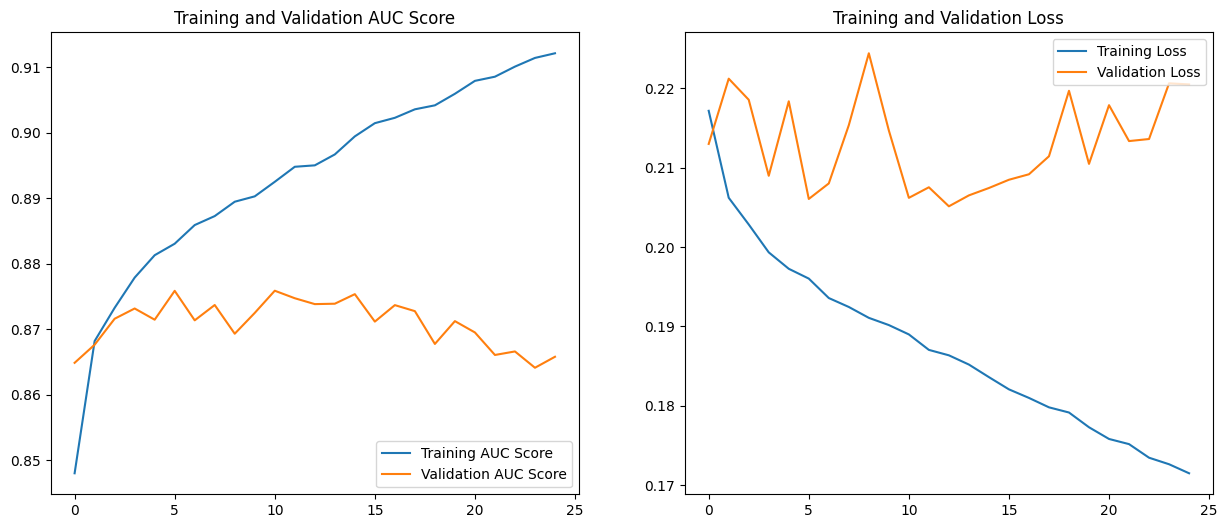

In [48]:
acc = history.history['auc_1']
val_acc = history.history['val_auc_1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC Score')
plt.plot(epochs_range, val_acc, label='Validation AUC Score')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Conclusion from Model 2::</font></h3>
    
- The precision score has improved as compared to the previous models.
- The model seems more stable with acceptable AUC score. 
- Overfitting of the model can also be avoided when after dealing with class imbalance. 

### Model 3: Using Keras Tuner
- Using Keras Tuner hyperparamter tuning can be done in deep learning models as well.
- In this case it is always advisable to focus on loss values of both the training and validation data since a model is considered more stable when the loss decreases with each epoch

In [57]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=[135]))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')]

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model

In [58]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5)

Reloading Tuner from ./untitled_project/tuner0.json


In [59]:
 # using early stopping to stop training the model when optimal value of recall and loss values are achieved.
 stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5)

In [60]:
tuner.search(X_train_new.values, y_train, epochs=25, validation_data = (X_test_new.values, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 00m 59s]
val_loss: 0.2102862298488617

Best val_loss So Far: 0.20548610389232635
Total elapsed time: 00h 36m 51s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



### Final Model after using Keras Tuner with optimal learning rate and number of units

In [61]:
model = Sequential()
model.add(Dense(384, input_dim=X_train_new.shape[-1], activation='relu'))
model.add(Dense(384, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve='ROC')]

### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=metrics)
### Training the model
epochs = 15
batch_size = 32
history = model.fit(X_train_new.values,y_train, 
                    validation_data = (X_test_new.values, y_test), 
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/15
1932/1932 [==============================] - 13s 6ms/step - loss: 0.2157 - precision: 0.6304 - recall: 0.1936 - auc_1: 0.8506 - val_loss: 0.2145 - val_precision: 0.7046 - val_recall: 0.2160 - val_auc_1: 0.8647
Epoch 2/15
1932/1932 [==============================] - 12s 6ms/step - loss: 0.2049 - precision: 0.6716 - recall: 0.2356 - auc_1: 0.8686 - val_loss: 0.2081 - val_precision: 0.7542 - val_recall: 0.1945 - val_auc_1: 0.8710
Epoch 3/15
1932/1932 [==============================] - 12s 6ms/step - loss: 0.2013 - precision: 0.6747 - recall: 0.2473 - auc_1: 0.8747 - val_loss: 0.2061 - val_precision: 0.7358 - val_recall: 0.2294 - val_auc_1: 0.8740
Epoch 4/15
1932/1932 [==============================] - 11s 6ms/step - loss: 0.1974 - precision: 0.6804 - recall: 0.2706 - auc_1: 0.8800 - val_loss: 0.2202 - val_precision: 0.5542 - val_recall: 0.4032 - val_auc_1: 0.8740
Epoch 5/15
1932/1932 [==============================] - 12s 6ms/step - loss: 0.1951 - precision: 0.6888 - recall: 0.

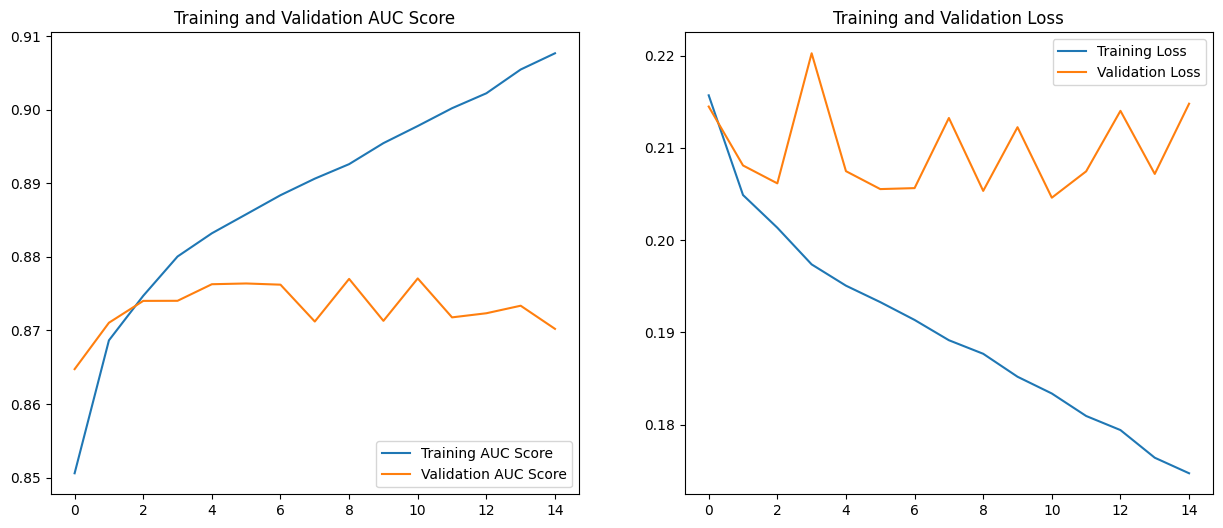

In [62]:
acc = history.history['auc_1']
val_acc = history.history['val_auc_1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC Score')
plt.plot(epochs_range, val_acc, label='Validation AUC Score')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Conclusion from the Final Model:</font></h3>

- The validation loss has decreased significantly.
- The precision and recall metrics are improved to some extent.
- The model is more generalized
- learning rate and number of units used are not random but calculated using proper methods. 